# The policemen burglar matrix game

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils import projection_simplex
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rc('legend', fontsize='xx-large')
plt.rc('legend', framealpha=0.98)
plt.rc('axes', labelsize='xx-large')

## Problem description

There are $n$ houses in a city, $i$-th with
wealth $w_i$. Every evening, the Burglar chooses a house $i$
to be attacked, and the Policeman chooses his post near
a house $j$. After the burglary starts, Policeman becomes
aware where it happens, and his probability to catch
the Burglar is $\exp\{−\theta dist(i, j)\}$, where
$dist(i, j)$ is the distance between houses $i$ and $j$.
The Burglar seeks to maximize his expected profit
$w_i(1 − \exp\{−\theta dist(i, j)\})$, and
the interest of Policeman is completely opposite.

- What are the optimal mixed strategies of Burglar and Policeman?

Equivalently solve the matrix game
$$
\min_{x\in\Delta} \, \max_{y\in\Delta}\, y^T Ax
$$
where $A_{ij} = w_i(1 − \exp\{−\theta dist(i, j)\})$.

See [this link](https://www2.isye.gatech.edu/~nemirovs/BrazilTransparenciesJuly4.pdf) for more details.

## Generating problem instances

In [4]:
def policeman_and_burglar_matrix(n, th=0.8):
    w = np.abs(np.random.randn(n))
    C = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            C[i,j] = np.abs(i-j)
    A = w[:, None] * (1 - np.exp(-th * C))
    return A

## Algorithms

In [5]:
def EG(x0, lr, F, max_iter=100, proj=None, gap=None):
    """The Extra gradient method"""

    if proj is None:
        proj = lambda x: x
    v = x0
    store_gap = [gap(x0)]

    for k in range(max_iter):

        # extrapolation step
        u = proj(v - lr * F(v))

        # update iterate
        v = proj(v - lr * F(u))

        if gap is not None:
            store_gap.append(gap(v))

    return store_gap

In [6]:
def GDA(x0, lr, F, max_iter=100, proj=None, gap=None):
    """Gradient Descent Ascent. Uses a naive evaluation of F."""

    if proj is None:
        proj = lambda x: x
    v = x0
    store_gap = [gap(x0)]

    for k in range(max_iter):

        # extrapolation step
        v = proj(v - lr * F(v))

        if gap is not None:
            store_gap.append(gap(v))

    return store_gap

### Min-Max specific generators

In [7]:
def make_F(A):
    """Saddle point operator of bilinear (square) min-max problem."""
    d = A.shape[1]

    def F(z):
        ret = np.zeros(2*d)
        ret[0:d] = A.T @ z[d:]
        ret[d:] = -A @ z[:d]
        return ret
    return F

In [8]:
def make_gap_fn(A):
    """Return the gap function for the specific problem instance."""
    
    def gap_fn(z):
        return np.max(A @ z[:d]) - np.min(A @ z[d:])
    return gap_fn

## Setup

In [9]:
np.random.seed(44)

In [10]:
d = 500
max_iter = 1000
A = policeman_and_burglar_matrix(d)
sp_norm = np.linalg.norm(A, 2)

def proj_double_simplex(z):
    return np.concatenate((projection_simplex(z[:d]), projection_simplex(z[d:])))
F_burgler = make_F(A)
gap_fn = make_gap_fn(A)

x0 = np.ones(2*d)/(d)

Stepsize has to be stricly less than $1/L$. But, to see intersting behavior the stepsize needs to be chosen much larger. Try also differen stepsizes for EG and GDA. You should observe that EG can tolerate higher ones!

In [25]:
lr = 100/sp_norm
print(lr)

0.20038568718855085


Run methods:

In [23]:
gaps_eg = EG(x0, lr, F_burgler, max_iter, proj_double_simplex, gap_fn)

gaps_gda = GDA(x0, lr, F_burgler, max_iter, proj_double_simplex, gap_fn)

do the plotting

Text(0.5, 1.0, 'primal dual gap')

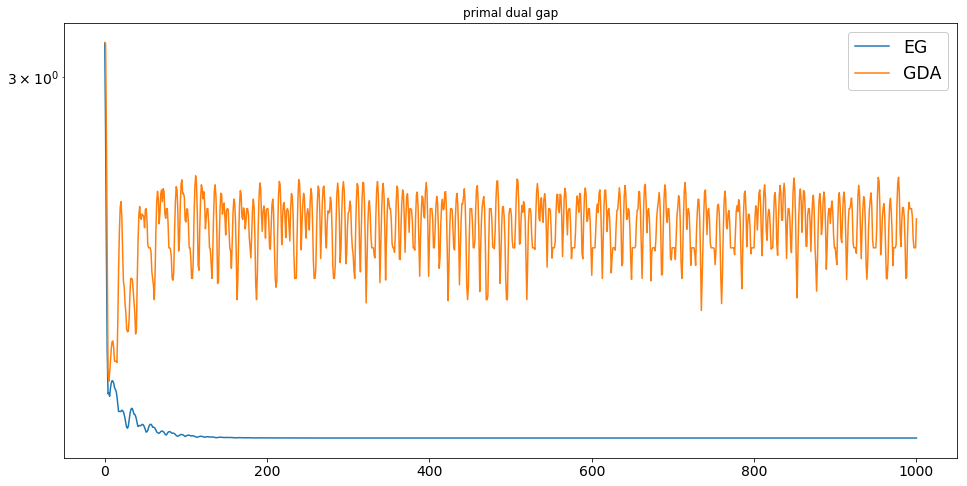

In [24]:
fig, ax = plt.subplots()
plt.plot(gaps_eg, label="EG")
plt.plot(gaps_gda, label="GDA")
plt.legend()
plt.yscale("log")
#plt.xscale("log")
plt.title("primal dual gap")

Text(0.5, 1.0, 'primal dual gap')

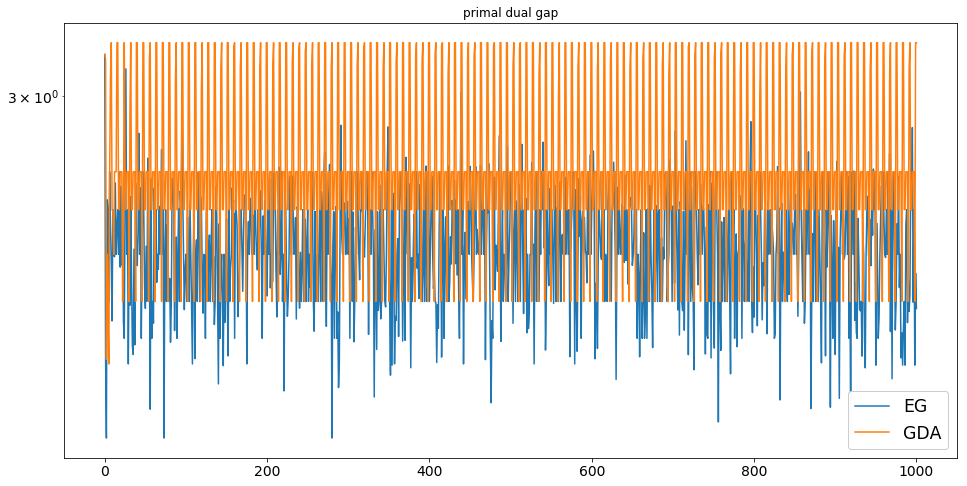

In [26]:
# larger learning rates
lr = 0.5

gaps_eg = EG(x0, lr, F_burgler, max_iter, proj_double_simplex, gap_fn)

gaps_gda = GDA(x0, lr, F_burgler, max_iter, proj_double_simplex, gap_fn)

fig, ax = plt.subplots()
plt.plot(gaps_eg, label="EG")
plt.plot(gaps_gda, label="GDA")
plt.legend()
plt.yscale("log")
#plt.xscale("log")
plt.title("primal dual gap")

# larger learning rates introduce more noise

Text(0.5, 1.0, 'primal dual gap')

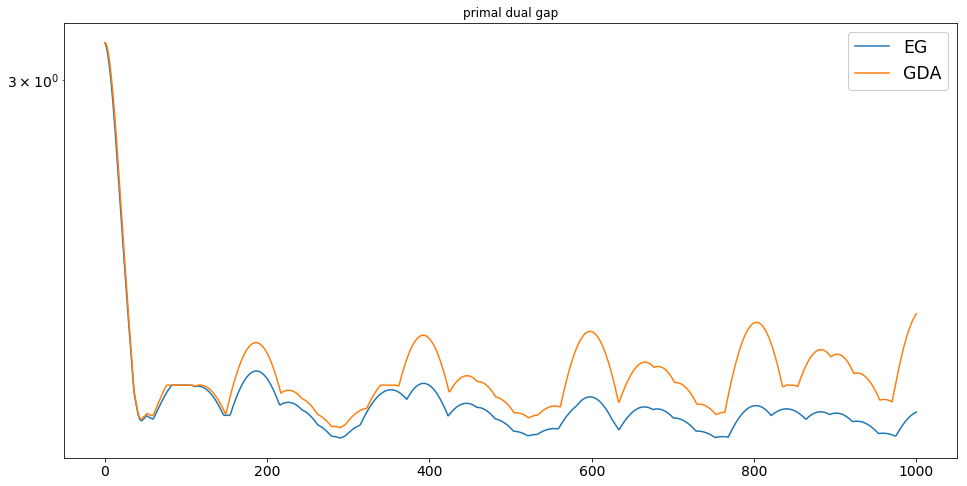

In [28]:
# smaller learning rates
lr = 0.01

gaps_eg = EG(x0, lr, F_burgler, max_iter, proj_double_simplex, gap_fn)

gaps_gda = GDA(x0, lr, F_burgler, max_iter, proj_double_simplex, gap_fn)

fig, ax = plt.subplots()
plt.plot(gaps_eg, label="EG")
plt.plot(gaps_gda, label="GDA")
plt.legend()
plt.yscale("log")
#plt.xscale("log")
plt.title("primal dual gap")

# smaller learning rates work better